Inspired from https://medium.com/@vaibhaw.vipul/building-autoencoder-in-pytorch-34052d1d280c and https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## Imports

In [2]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

In [7]:
import sys
sys.path.append('../')

from .display import show_some
from .summary import summarize
from utils.TrainedModels import save_trained, load_trained
from models.SmallConvAutoencoderModel import Autoencoder

## Loading and Transforming data

In [4]:
# Loading and Transforming data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4466),
                                                     (0.247, 0.243, 0.261))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(),
                                         tv.transforms.Normalize((0.4914, 0.4822, 0.4466),
                                                                 (0.247, 0.243, 0.261))])
trainset = tv.datasets.CIFAR10(root='./data',
                               train=True,
                               download=True,
                               transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                         batch_size=8,
                                         shuffle=False,
                                         num_workers=4)
testset = tv.datasets.CIFAR10(root='./data',
                              train=False,
                              download=True,
                              transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4,
                                         shuffle=False,
                                         num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


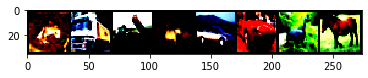

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


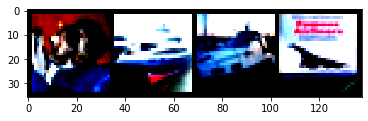

In [6]:
# get some random images
show_some(trainloader)
show_some(testloader)

## About the model

In [9]:
model = Autoencoder().cuda()
distance = nn.MSELoss().cuda() #We can modify this, eg input and output must have same edges, we should experiment differents ones
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)

In [10]:
summarize(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
            Conv2d-3           [-1, 16, 24, 24]           2,416
              ReLU-4           [-1, 16, 24, 24]               0
   ConvTranspose2d-5            [-1, 6, 28, 28]           2,406
              ReLU-6            [-1, 6, 28, 28]               0
   ConvTranspose2d-7            [-1, 3, 32, 32]             453
              ReLU-8            [-1, 3, 32, 32]               0
Total params: 5,731
Trainable params: 5,731
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.33
Params size (MB): 0.02
Estimated Total Size (MB): 0.36
----------------------------------------------------------------
None


## Training

In [8]:
#defining some params
num_epochs = 5 #you can go for more epochs
batch_size = 128

The 2 next cells should be in train.py inside a def train(model, loss, trainloader, groundtruthes, params):

In [10]:
for epoch in range(num_epochs):
    for data in trainloader:
        img, _ = data
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(img)
        groundtruth = img #In order to transform "north" to "south", our inputs can be the "north" images, groundtruth is corresponding "south" image
        loss = distance(output, groundtruth)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.data))
print('Finished Training')

epoch [1/5], loss:0.3669
epoch [2/5], loss:0.3610
epoch [3/5], loss:0.3591
epoch [4/5], loss:0.3583
epoch [5/5], loss:0.3579
Finished Training


A part of the next cell should be in utils/save_model.py

In [11]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

The 4 next cells should be in test.py inside a def test(model, trained_state, testloader, groundtruthes, params):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


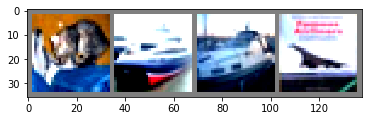

In [12]:
dataiter = iter(testloader)
images, _ = dataiter.next()
# print images
imshow(tv.utils.make_grid(images))

In [13]:
model = Autoencoder()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [14]:
outputs = model(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


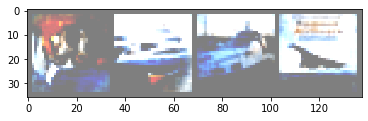

In [15]:
# print images
imshow(tv.utils.make_grid(outputs.detach()))